In [26]:
from __future__ import division

import numpy as np
import pandas as pd

import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [27]:
#Reading milk data
milk = pd.read_csv('monthly-milk-production.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   milk    168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


In [28]:
milk.head()

,milk
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


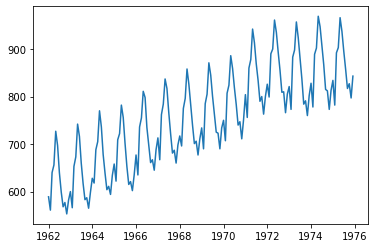

In [29]:
_ = plt.plot(milk.index, milk.values)

In [33]:
test = sm.tsa.stattools.adfuller(milk.values.flatten())
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -1.3038115874221294
p-value:  0.6274267086030316
Critical values:  {'1%': -3.473542528196209, '5%': -2.880497674144038, '10%': -2.576878053634677}
есть единичные корни, ряд не стационарен


Часто, когда вы имеете дело с величинами, представляющими собой сумму значений показателя за каждый день или за каждый рабочий день, имеет смысл перед началом прогнозирования поделить весь ряд на число дней в периоде. Например, если поделить ряд с объёмом производства молока на одну корову на число дней в месяце, полученная величина будет меняться более плавно, и для неё легче будет построить прогнозирующую модель.

Корректно определить число дней в месяце можно с помощью свойства days_in_month у индекса ряда или функции monthrange из пакета calendar. Используйте число дней в месяце для того, чтобы вычислить новый показатель — среднее дневное число полученного молока на одну корову. Постройте график этого ряда и убедитесь, что он стал более гладким.

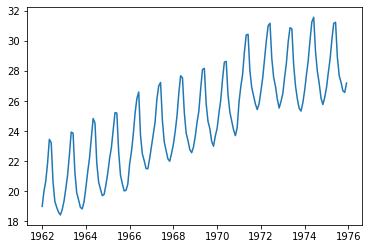

In [6]:
milk['daily'] = milk.milk.values.flatten() / milk.index.days_in_month
_ = plt.plot(milk.index, milk.daily)

In [7]:
milk.daily.values.sum()

4166.326661899466

Для ряда со средним дневным количеством молока на корову из предыдущего вопроса давайте с помощью критерия Дики-Фуллера подберём порядок дифференцирования, при котором ряд становится стационарным.

Дифференцирование можно делать так:

milk.daily_diff1 = milk.daily - milk.daily.shift(1)

Чтобы сделать сезонное дифференцирование, нужно изменить значение параметра у функции shift:

milk.daily_diff12 = milk.daily - milk.daily.shift(12)

При дифференцировании длина ряда сокращается, поэтому в части строк в новой колонке значения будут не определены (NaN). Подавая полученные столбцы на вход критерию Дики-Фуллера, отрезайте неопределённые значения, иначе вы получите неопределённый достигаемый уровень значимости.

<ipython-input-8-dc126ba64700>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  milk.daily_diff1 = milk.daily - milk.daily.shift(1)


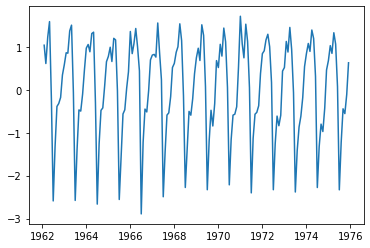

In [8]:
milk.daily_diff1 = milk.daily - milk.daily.shift(1)
_ = plt.plot(milk.index, milk.daily_diff1)

In [9]:
sm.tsa.stattools.adfuller(milk.daily_diff1.dropna())

(-2.7594694762289365,
 0.06430054654174293,
 11,
 155,
 {'1%': -3.4732590518613002,
  '5%': -2.880374082105334,
  '10%': -2.5768120811654525},
 -1.1539973381055688)

<ipython-input-10-be6c277cf8c3>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  milk.daily_diff12 = milk.daily - milk.daily.shift(12)


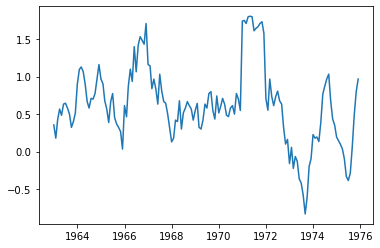

In [10]:
milk.daily_diff12 = milk.daily - milk.daily.shift(12)
_ = plt.plot(milk.index, milk.daily_diff12)

In [11]:
sm.tsa.stattools.adfuller(milk.daily_diff12.dropna())

(-2.1594860932888076,
 0.22127672658830383,
 12,
 143,
 {'1%': -3.4769274060112707,
  '5%': -2.8819726324025625,
  '10%': -2.577665408088415},
 -25.225679141303317)

<ipython-input-12-b1a8af28cbc8>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  milk.daily_diff12_1 = milk.daily_diff12 - milk.daily_diff12.shift(1)


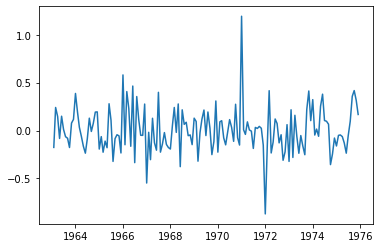

In [12]:
milk.daily_diff12_1 = milk.daily_diff12 - milk.daily_diff12.shift(1)
_ = plt.plot(milk.index, milk.daily_diff12_1)

In [13]:
sm.tsa.stattools.adfuller(milk.daily_diff12_1.dropna())

(-5.481326334796932,
 2.2808455518036712e-06,
 11,
 143,
 {'1%': -3.4769274060112707,
  '5%': -2.8819726324025625,
  '10%': -2.577665408088415},
 -20.90513750989237)

Для стационарного ряда из предыдущего вопроса постройте график автокорреляционной функции.

(<Figure size 432x288 with 1 Axes>,)

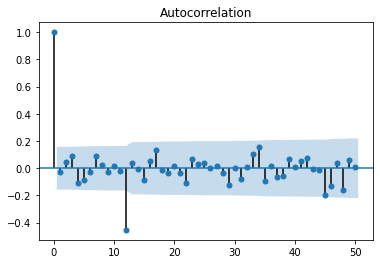

In [14]:
sm.graphics.tsa.plot_acf(milk.daily_diff12_1.dropna().values.squeeze(), lags=50),

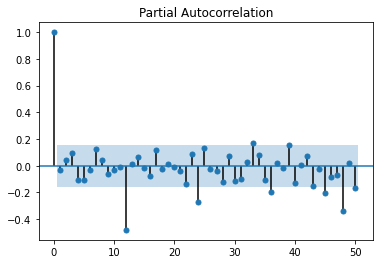

In [15]:
sm.graphics.tsa.plot_pacf(milk.daily_diff12_1.dropna().values.squeeze(), lags=50);